In [1]:
domains = ['photo', 'art_painting', 'cartoon', 'sketch']
classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse','house', 'person']

# Set parameters

In [2]:
import torch
import torchvision.transforms as transforms

from torchvision import models
from torchvision.datasets import ImageFolder, DatasetFolder
import torchvision.datasets as Datasets
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch import nn, optim
from collections import OrderedDict

#Modify
from utils_byol_training import *
import os

import numpy as np
import matplotlib.pyplot as plt

# model selection
from model.resnet_original import resnet18
from model.feature_mixer import Feature_mixer


#BYOL 관련 Import
import argparse
import multiprocessing
from pathlib import Path
from PIL import Image

from byol.byol_pytorch import BYOL
from utils.utils_byol import *
import copy


##############################
# Training Setting
##############################
used_model = 'resnet18'  # 'resnet18' or 'resnet18_classic'
dataset ='pacs'
save_name = 'pacs_byol'
pacs_ver = 'pacs_official_split' # 'pacs_official_unseen' or 'pacs_official_split'
number_of_tests = 1

##############################
# BYOL Hyper-parameters
##############################

byol_batch_size = 128
byol_epochs     = 1 # 원래 100
byol_lr         = 3e-4
byol_image_size = 224
# byol_num_gps   = 1
# byol_image_exts = ['.jpg', '.png', '.jpeg']
# byol_num_workers = multiprocessing.cpu_count()

#byol conv layer freeze 하고 linear layer 학습할지 여부
is_byol_conv_freeze=False

##############################
# Fine-tune Hyper-parameters
##############################
training_setting = 'byol' # 'classic' or 'di' or 'cc'(and di) or 'fm' or 'byol'
epochs = [1]
batch_size = 128
is_pretrained = True
is_domain_vec = False
is_dc = False
color_jitter = True

lr = 1e-4
lr_decay_epoch = [10000]
lr_decay_gamma = 0.5
gamma_d_loss = 0.5
entropy_weight = 0.5
gpu_num = 0


device= torch.device('cpu')
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
    device = torch.device("cuda:{}".format(gpu_num))
print(device)

criterion = nn.CrossEntropyLoss().to(device)


#Modify
train_tf, test_tf = get_tf(color_jitter, augment=True)

#추가 : byol  관련 파라미터 
#모델 세팅 저장 
model_settings={
    "used_model" : used_model,
    "dataset" : dataset,
    "save_name" : save_name,
    "pacs_ver" : pacs_ver,
    "number_of_tests" : number_of_tests,
    "training_setting" : training_setting,
    "epochs" : epochs,
    "batch_size" : batch_size,
    "is_pretrained" : is_pretrained,
    "is_domain_vec" : is_domain_vec,
    "is_dc" : is_dc,
    "color_jitter" : color_jitter,
    "lr" : lr,
    "lr_decay_epoch" : lr_decay_epoch,
    "lr_decay_gamma" : lr_decay_gamma,
    "gamma_d_loss" : gamma_d_loss,
    "entropy_weight" : entropy_weight,
    "gpu_num" : gpu_num
}

if training_setting=="byol":
    model_settings['byol_batch_size']=byol_batch_size
    model_settings['byol_epochs']=byol_epochs
    model_settings['byol_lr']=byol_lr
    model_settings['byol_image_size']=byol_image_size
    model_settings['is_byol_conv_freeze']=is_byol_conv_freeze

Using CUDA
cuda:0


# Functions

In [3]:
def classic_setting(test_domain_idx, domains, batch_size, is_pretrained, train_tf, test_tf, used_model,pacs_ver):
    
    train_set1 = ImageFolder(root=os.path.join('{}/train'.format(pacs_ver),
                                               domains[(test_domain_idx+1)%len(domains)]), transform = train_tf)
    train_set2 = ImageFolder(root=os.path.join('{}/train'.format(pacs_ver),
                                               domains[(test_domain_idx+2)%len(domains)]), transform = train_tf)
    train_set3 = ImageFolder(root=os.path.join('{}/train'.format(pacs_ver),
                                               domains[(test_domain_idx+3)%len(domains)]), transform = train_tf)
        
    val_set1 = ImageFolder(root=os.path.join('{}/val'.format(pacs_ver),
                                               domains[(test_domain_idx+1)%len(domains)]), transform = test_tf)
    val_set2 = ImageFolder(root=os.path.join('{}/val'.format(pacs_ver),
                                               domains[(test_domain_idx+2)%len(domains)]), transform = test_tf)
    val_set3 = ImageFolder(root=os.path.join('{}/val'.format(pacs_ver),
                                               domains[(test_domain_idx+3)%len(domains)]), transform = test_tf)
    
    train_set = train_set1+train_set2+train_set3
    val_set = val_set1+val_set2+val_set3
    test_set = ImageFolder(root=os.path.join('{}/test'.format(pacs_ver),domains[test_domain_idx]), transform = test_tf)
    
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=6)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=6)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=6)
    
    if used_model=='vgg16':
        print('vgg16')
        model = models.vgg16(pretrained=is_pretrained).cuda()
        model.classifier[6].out_features=7
    elif used_model=='inceptionv3':
        model = models.inception_v3(pretrained=is_pretrained).cuda()
        model.AuxLogits.fc.out_features = 7
        model.fc.out_features=7
    elif used_model=='resnet18':
        # load weights pretrained on ImageNet
        model = resnet18(pretrained=is_pretrained)        
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,len(classes))
        model = model.to(device)
    elif used_model=='resnet18_classic':
        model = models.resnet18(pretrained=is_pretrained)        
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,len(classes))
        model = model.to(device)
    else:
        raise NotImplementedError

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_decay_epoch, gamma= lr_decay_gamma)  
    
    return train_loader, val_loader, test_loader, optimizer, model, scheduler

def di_setting(test_domain_idx,domains, batch_size, is_pretrained, train_tf, test_tf, used_model,pacs_ver):
    domain_photo = torch.tensor([1.,0.,0.,0.,0.])
    domain_art_painting = torch.tensor([0.,1.,0.,0.,0.])
    domain_cartoon = torch.tensor([0.,0.,1.,0.,0.])
    domain_sketch = torch.tensor([0.,0.,0.,1.,0.])
    unseen_domain = torch.tensor([0.,0.,0.,0.,1.])
    domain_list=[domain_art_painting,domain_cartoon,domain_photo,domain_sketch]
    
    train_set1 = DGImageFolder(domain=domain_list[(test_domain_idx+1)%len(domains)],
                               root=os.path.join('{}/train'.format(pacs_ver),domains[(test_domain_idx+1)%len(domains)]),
                               transform = train_tf)
    train_set2 = DGImageFolder(domain=domain_list[(test_domain_idx+2)%len(domains)],
                               root=os.path.join('{}/train'.format(pacs_ver),domains[(test_domain_idx+2)%len(domains)]),
                               transform = train_tf)
    train_set3 = DGImageFolder(domain=domain_list[(test_domain_idx+3)%len(domains)],
                               root=os.path.join('{}/train'.format(pacs_ver),domains[(test_domain_idx+3)%len(domains)]),
                               transform = train_tf)
    
    unseen_train_set_1=DGImageFolder(domain=unseen_domain, 
                                     root=os.path.join('{}/train/unseen'.format(pacs_ver),domains[(test_domain_idx+1)%len(domains)]),
                                     transform = train_tf)
    unseen_train_set_2=DGImageFolder(domain=unseen_domain, 
                                     root=os.path.join('{}/train/unseen'.format(pacs_ver),domains[(test_domain_idx+2)%len(domains)]),
                                     transform = train_tf)
    unseen_train_set_3=DGImageFolder(domain=unseen_domain, 
                                     root=os.path.join('{}/train/unseen'.format(pacs_ver),domains[(test_domain_idx+3)%len(domains)]),
                                     transform = train_tf)
    
    train_set = train_set1+train_set2+train_set3+unseen_train_set_1+unseen_train_set_2+unseen_train_set_3
    
    val_set1 = DGImageFolder(domain=domain_list[(test_domain_idx+1)%len(domains)],
                               root=os.path.join('{}/val'.format(pacs_ver),domains[(test_domain_idx+1)%len(domains)]),
                               transform = test_tf)
    val_set2 = DGImageFolder(domain=domain_list[(test_domain_idx+2)%len(domains)],
                               root=os.path.join('{}/val'.format(pacs_ver),domains[(test_domain_idx+2)%len(domains)]),
                               transform = test_tf)
    val_set3 = DGImageFolder(domain=domain_list[(test_domain_idx+3)%len(domains)],
                               root=os.path.join('{}/val'.format(pacs_ver),domains[(test_domain_idx+3)%len(domains)]),
                               transform = test_tf)
    
    val_set = val_set1 + val_set2 + val_set3
    
    test_set = DGImageFolder(domain=unseen_domain, root=os.path.join('{}/test'.format(pacs_ver),domains[test_domain_idx]), transform = test_tf)
    
    print(len(train_set),len(val_set), len(test_set))
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=6,
                             drop_last=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=6)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=6)
    
    if used_model=='vgg16':
        print('vgg16')
        model = models.vgg16(pretrained=is_pretrained).to(device)
        model.classifier[6].out_features=7
    elif used_model=='inceptionv3':
        model = models.inception_v3(pretrained=is_pretrained).to(device)
        model.AuxLogits.fc.out_features = 7
        model.fc.out_features=7
    elif used_model=='resnet18':
        # load weights pretrained on ImageNet
        model = resnet18(pretrained=is_pretrained)        
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,7)
        model = model.to(device)
    elif used_model=='resnet18_classic':
        model = models.resnet18(pretrained=is_pretrained)        
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,7)
        model = model.to(device)
    else:
        raise NotImplementedError
        
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[lr_decay_epoch], gamma= lr_decay_gamma)  
    
    return train_loader, val_loader, test_loader, optimizer, model,scheduler

def cc_setting(test_domain_idx,domains, batch_size, is_pretrained, train_tf, test_tf, used_model,pacs_ver):
    
    domain_art_painting = torch.tensor([1.,0.,0.,0.,0.])
    domain_cartoon = torch.tensor([0.,1.,0.,0.,0.])
    domain_photo = torch.tensor([0.,0.,1.,0.,0.])
    domain_sketch = torch.tensor([0.,0.,0.,1.,0.])
    unseen_domain = torch.tensor([0.,0.,0.,0.,1.])
    domain_list = [domain_photo, domain_art_painting, domain_cartoon, domain_sketch]
    
    
    check = 1
    train_set = 0
    val_set = 0
    check_limit = 2
    
    for i in range(4):
        if check > check_limit:
            break
        if i==test_domain_idx:
            continue
        
        temp = DGImageFolder(domain=domain_list[i],
                           root=os.path.join('{}/train'.format(pacs_ver),domains[i]),
                           transform = train_tf)
        temp_unseen = DGImageFolder(domain=unseen_domain, 
                             root=os.path.join('{}/train/unseen'.format(pacs_ver),domains[i]),
                             transform = train_tf)
        temp_val = DGImageFolder(domain=domain_list[i],
                               root=os.path.join('{}/val'.format(pacs_ver),domains[i]),
                               transform = test_tf)
        if check==1:
            train_set = temp
            val_set = temp_val
        else:
            train_set += temp
            val_set += temp_val
        
        train_set += temp_unseen
        check += 1
    
    train_set_stage1 = train_set
    val_set_stage1 = val_set
    
    
    #이것만 학습에 들어감 
    check = 1
    train_set = 0
    val_set = 0
    check_limit = 3
    
    for i in range(4):
        if check > check_limit:
            break
        if i==test_domain_idx:
            continue
        
        temp = DGImageFolder(domain=domain_list[i],
                           root=os.path.join('{}/train'.format(pacs_ver),domains[i]),
                           transform = train_tf)
        temp_unseen = DGImageFolder(domain=unseen_domain, 
                             root=os.path.join('{}/train/unseen'.format(pacs_ver),domains[i]),
                             transform = train_tf)
        temp_val = DGImageFolder(domain=unseen_domain,
                               root=os.path.join('{}/val'.format(pacs_ver),domains[i]),
                               transform = test_tf)
        if check==1:
            train_set = temp
            val_set = temp_val
        else:
            train_set += temp
            val_set += temp_val
        
        train_set += temp_unseen
        check += 1
    
    train_set_stage2 = train_set
    val_set_stage2 = val_set


                             

    
    test_set = DGImageFolder(domain=unseen_domain, root=os.path.join('{}/test'.format(pacs_ver),domains[test_domain_idx]), transform = test_tf)
    
    print('stage1 :',len(train_set_stage1),len(val_set_stage1), len(test_set))
    print('stage2 :',len(train_set_stage2),len(val_set_stage2), len(test_set))
    
    train_loader_stage1 = DataLoader(train_set_stage1, batch_size=batch_size, shuffle=True, num_workers=6,
                             drop_last=True)
    val_loader_stage1 = DataLoader(val_set_stage1, batch_size=batch_size, shuffle=False, num_workers=6)
    
    train_loader_stage2 = DataLoader(train_set_stage2, batch_size=batch_size, shuffle=True, num_workers=6,
                             drop_last=True)
    val_loader_stage2 = DataLoader(val_set_stage2, batch_size=batch_size, shuffle=False, num_workers=6)
    
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=6)
    
    if used_model=='vgg16':
        print('vgg16')
        model = models.vgg16(pretrained=is_pretrained).to(device)
        model.classifier[6].out_features=7
    elif used_model=='inceptionv3':
        model = models.inception_v3(pretrained=is_pretrained).to(device)
        model.AuxLogits.fc.out_features = 7
        model.fc.out_features=7
    elif used_model=='resnet18':
        # load weights pretrained on ImageNet
        model = resnet18(pretrained=is_pretrained)        
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,7)
        model = model.to(device)
    elif used_model=='resnet18_classic':
        model = models.resnet18(pretrained=is_pretrained)        
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,7)
        model = model.to(device)
    else:
        raise NotImplementedError
        
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[lr_decay_epoch], gamma= lr_decay_gamma)  
    
    return train_loader_stage1,train_loader_stage2, val_loader_stage1, val_loader_stage2, test_loader, optimizer, model,scheduler

def fm_setting(test_domain_idx,domains, batch_size, is_pretrained, train_tf, test_tf, used_model,pacs_ver):
#     domain_photo = torch.tensor([1.,0.,0.,0.,0.])
#     domain_art_painting = torch.tensor([0.,1.,0.,0.,0.])
#     domain_cartoon = torch.tensor([0.,0.,1.,0.,0.])
#     domain_sketch = torch.tensor([0.,0.,0.,1.,0.])
#     unseen_domain = torch.tensor([0.,0.,0.,0.,1.])
#     domain_list=[domain_photo,domain_art_painting,domain_cartoon,domain_sketch]
    
#     train_set1 = DGImageFolder(domain=domain_list[(test_domain_idx+1)%len(domains)],
#                                root=os.path.join('{}/train'.format(pacs_ver),domains[(test_domain_idx+1)%len(domains)]),
#                                transform = train_tf)
#     train_set2 = DGImageFolder(domain=domain_list[(test_domain_idx+2)%len(domains)],
#                                root=os.path.join('{}/train'.format(pacs_ver),domains[(test_domain_idx+2)%len(domains)]),
#                                transform = train_tf)
#     train_set3 = DGImageFolder(domain=domain_list[(test_domain_idx+3)%len(domains)],
#                                root=os.path.join('{}/train'.format(pacs_ver),domains[(test_domain_idx+3)%len(domains)]),
#                                transform = train_tf)

    
#     train_set = train_set1+train_set2+train_set3
    
#     val_set1 = DGImageFolder(domain=domain_list[(test_domain_idx+1)%len(domains)],
#                                root=os.path.join('{}/val'.format(pacs_ver),domains[(test_domain_idx+1)%len(domains)]),
#                                transform = test_tf)
#     val_set2 = DGImageFolder(domain=domain_list[(test_domain_idx+2)%len(domains)],
#                                root=os.path.join('{}/val'.format(pacs_ver),domains[(test_domain_idx+2)%len(domains)]),
#                                transform = test_tf)
#     val_set3 = DGImageFolder(domain=domain_list[(test_domain_idx+3)%len(domains)],
#                                root=os.path.join('{}/val'.format(pacs_ver),domains[(test_domain_idx+3)%len(domains)]),
#                                transform = test_tf)
    
#     val_set = val_set1 + val_set2 + val_set3
    
#     test_set = DGImageFolder(domain=unseen_domain, root=os.path.join('{}/test'.format(pacs_ver),domains[test_domain_idx]), transform = test_tf)
    
#     print(len(train_set),len(val_set), len(test_set))
    
#     train_loader_stage1 = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=6,drop_last=True)
#     train_loader_stage2 = DataLoader(train_set, batch_size=batch_size-int(batch_size/4), shuffle=True, num_workers=6, drop_last=True)
#     val_loader_stage1 = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=6, drop_last=True)
#     val_loader_stage2 = DataLoader(val_set, batch_size=batch_size-int(batch_size/4), shuffle=True, num_workers=6,drop_last=True)
#     test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=6)

    domain_photo = torch.tensor([1.,0.,0.,0.,0.])
    domain_art_painting = torch.tensor([0.,1.,0.,0.,0.])
    domain_cartoon = torch.tensor([0.,0.,1.,0.,0.])
    domain_sketch = torch.tensor([0.,0.,0.,1.,0.])
    unseen_domain = torch.tensor([0.,0.,0.,0.,1.])
    domain_list = [domain_photo,domain_art_painting,domain_cartoon,domain_sketch]
    
    
    check = 1
    train_set = 0
    val_set = 0
    check_limit = 2
    
    for i in range(4):
        if check > check_limit:
            break
        if i==test_domain_idx:
            continue
        
        temp = DGImageFolder(domain=domain_list[i],
                           root=os.path.join('{}/train'.format(pacs_ver),domains[i]),
                           transform = train_tf)
        temp_val = DGImageFolder(domain=unseen_domain,
                               root=os.path.join('{}/val'.format(pacs_ver),domains[i]),
                               transform = test_tf)
        if check==1:
            train_set = temp
            val_set = temp_val
        else:
            train_set += temp
            val_set += temp_val
        
        check += 1
    
    train_set_stage1 = train_set
    val_set_stage1 = val_set
    
    
    check = 1
    train_set = 0
    val_set = 0
    check_limit = 3
    
    for i in range(4):
        if check > check_limit:
            break
        if i==test_domain_idx:
            continue
        
        temp = DGImageFolder(domain=domain_list[i],
                           root=os.path.join('{}/train'.format(pacs_ver),domains[i]),
                           transform = train_tf)
        temp_val = DGImageFolder(domain=unseen_domain,
                               root=os.path.join('{}/val'.format(pacs_ver),domains[i]),
                               transform = test_tf)
        if check==1:
            train_set = temp
            val_set = temp_val
        else:
            train_set += temp
            val_set += temp_val
        
        check += 1
    
    train_set_stage2 = train_set
    val_set_stage2 = val_set


    test_set = DGImageFolder(domain=unseen_domain, root=os.path.join('{}/test'.format(pacs_ver),domains[test_domain_idx]), transform = test_tf)
    
    print('stage1 :',len(train_set_stage1),len(val_set_stage1), len(test_set))
    print('stage2 :',len(train_set_stage2),len(val_set_stage2), len(test_set))
    
    train_loader_stage1 = DataLoader(train_set_stage1, batch_size=batch_size-int(batch_size/4), shuffle=True, num_workers=6,
                             drop_last=True)
    val_loader_stage1 = DataLoader(val_set_stage1, batch_size=batch_size, shuffle=True, num_workers=6,drop_last=True)
    
    train_loader_stage2 = DataLoader(train_set_stage2, batch_size=batch_size-int(batch_size/4), shuffle=True, num_workers=6,
                             drop_last=True)
    val_loader_stage2 = DataLoader(val_set_stage2, batch_size=batch_size, shuffle=True, num_workers=6,drop_last=True)
    
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=6)

    if used_model=='vgg16':
        print('vgg16')
        model = models.vgg16(pretrained=is_pretrained).to(device)
        model.classifier[6].out_features=7
    elif used_model=='inceptionv3':
        model = models.inception_v3(pretrained=is_pretrained).to(device)
        model.AuxLogits.fc.out_features = 7
        model.fc.out_features=7
    elif used_model=='resnet18':
        # load weights pretrained on ImageNet
        model = resnet18(pretrained=is_pretrained)        
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,len(classes))
        model = model.to(device)
    elif used_model=='resnet18_classic':
        model = models.resnet18(pretrained=is_pretrained)        
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,len(classes))
        model = model.to(device)
    elif used_model=='alexnet':
        model = alexnet(pretrained=is_pretrained) 
        model.classifier[-1]= nn.Linear(4096,len(classes))
        model = model.to(device)
    elif used_model=='alexnet_classic':
        model = models.alexnet(pretrained=is_pretrained) 
        model.classifier[-1]= nn.Linear(4096,len(classes))
        model = model.to(device)
    else:
        raise NotImplementedError
    
    mixer = Feature_mixer().to(device)
        
    optimizer = optim.Adam(model.parameters(), lr=lr)
    fm_optimizer = optim.Adam(mixer.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[lr_decay_epoch], gamma= lr_decay_gamma)  
    
    return train_loader_stage1, train_loader_stage2 , val_loader_stage1, val_loader_stage2, test_loader, optimizer, fm_optimizer, model, mixer, scheduler

def byol_setting(test_domain_idx, domains, batch_size, is_pretrained):
    
    train_loaders=dict()
    
    for c in classes:
        #setting
        train_set1 = ImagesDataset(os.path.join('{}/train'.format(pacs_ver),
                                                   domains[(test_domain_idx+1)%len(domains)],c),byol_image_size)
        train_set2 = ImagesDataset(os.path.join('{}/train'.format(pacs_ver),
                                                   domains[(test_domain_idx+2)%len(domains)],c),byol_image_size)
        train_set3 = ImagesDataset(os.path.join('{}/train'.format(pacs_ver),
                                                   domains[(test_domain_idx+3)%len(domains)],c),byol_image_size)

        train_set = train_set1+train_set2+train_set3
        
        #NUM_WORKERS 변경 
        for i in range (2):
            train_loaders[c+"_"+str(i)] = DataLoader(train_set, batch_size=batch_size, num_workers=0, shuffle=True)
    
    
    if used_model=='resnet18':
        # load weights pretrained on ImageNet
        print("여부",is_pretrained)
        model = resnet18(pretrained=is_pretrained)        
    elif used_model=='resnet18_classic':
        model = models.resnet18(pretrained=is_pretrained)        
    else:
        raise NotImplementedError
     
    return model,train_loaders

def byol_classic_setting(model,test_domain_idx, domains, batch_size, is_pretrained, train_tf, test_tf, used_model,pacs_ver):
    
    train_set1 = ImageFolder(root=os.path.join('{}/train'.format(pacs_ver),
                                               domains[(test_domain_idx+1)%len(domains)]), transform = train_tf)
    train_set2 = ImageFolder(root=os.path.join('{}/train'.format(pacs_ver),
                                               domains[(test_domain_idx+2)%len(domains)]), transform = train_tf)
    train_set3 = ImageFolder(root=os.path.join('{}/train'.format(pacs_ver),
                                               domains[(test_domain_idx+3)%len(domains)]), transform = train_tf)
        
    val_set1 = ImageFolder(root=os.path.join('{}/val'.format(pacs_ver),
                                               domains[(test_domain_idx+1)%len(domains)]), transform = test_tf)
    val_set2 = ImageFolder(root=os.path.join('{}/val'.format(pacs_ver),
                                               domains[(test_domain_idx+2)%len(domains)]), transform = test_tf)
    val_set3 = ImageFolder(root=os.path.join('{}/val'.format(pacs_ver),
                                               domains[(test_domain_idx+3)%len(domains)]), transform = test_tf)
    
    train_set = train_set1+train_set2+train_set3
    val_set = val_set1+val_set2+val_set3
    test_set = ImageFolder(root=os.path.join('{}/test'.format(pacs_ver),domains[test_domain_idx]), transform = test_tf)
    
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_decay_epoch, gamma= lr_decay_gamma)  
    
    return train_loader, val_loader, test_loader, optimizer, model, scheduler

# Automation

여부 True
BYOL Training Start!
BYOL Epoch: 1 [128/7478 (2%)],	 Loss: 3.863209
BYOL Epoch: 1 [256/7478 (3%)],	 Loss: 2.559857
BYOL Epoch: 1 [384/7478 (5%)],	 Loss: 2.181070
BYOL Epoch: 1 [512/7478 (7%)],	 Loss: 2.037012
BYOL Epoch: 1 [640/7478 (9%)],	 Loss: 1.977959
BYOL Epoch: 1 [768/7478 (10%)],	 Loss: 1.921974
BYOL Epoch: 1 [896/7478 (12%)],	 Loss: 1.909256
BYOL Epoch: 1 [1024/7478 (14%)],	 Loss: 1.894120
BYOL Epoch: 1 [1152/7478 (15%)],	 Loss: 1.876468
BYOL Epoch: 1 [1280/7478 (17%)],	 Loss: 1.879770
BYOL Epoch: 1 [1385/7478 (19%)],	 Loss: 1.868976
BYOL Epoch: 1 [1513/7478 (20%)],	 Loss: 1.874537
BYOL Epoch: 1 [1641/7478 (22%)],	 Loss: 1.875704
BYOL Epoch: 1 [1769/7478 (24%)],	 Loss: 1.872128
BYOL Epoch: 1 [1897/7478 (25%)],	 Loss: 1.870167
BYOL Epoch: 1 [2025/7478 (27%)],	 Loss: 1.859357
BYOL Epoch: 1 [2153/7478 (29%)],	 Loss: 1.862580
BYOL Epoch: 1 [2281/7478 (31%)],	 Loss: 1.865765
BYOL Epoch: 1 [2409/7478 (32%)],	 Loss: 1.875047
BYOL Epoch: 1 [2537/7478 (34%)],	 Loss: 1.880400
BYO

Epoch: 1 [1152/7478 (15%)],	Accuracy: 29.7%,  	 Loss: 1.934658
Epoch: 1 [1280/7478 (17%)],	Accuracy: 26.6%,  	 Loss: 1.862675
Epoch: 1 [1408/7478 (19%)],	Accuracy: 32.8%,  	 Loss: 1.917690
Epoch: 1 [1536/7478 (20%)],	Accuracy: 39.1%,  	 Loss: 1.763749
Epoch: 1 [1664/7478 (22%)],	Accuracy: 27.3%,  	 Loss: 1.795865
Epoch: 1 [1792/7478 (24%)],	Accuracy: 26.6%,  	 Loss: 1.760242
Epoch: 1 [1920/7478 (25%)],	Accuracy: 40.6%,  	 Loss: 1.695852
Epoch: 1 [2048/7478 (27%)],	Accuracy: 30.5%,  	 Loss: 1.753803
Epoch: 1 [2176/7478 (29%)],	Accuracy: 35.9%,  	 Loss: 1.679090
Epoch: 1 [2304/7478 (31%)],	Accuracy: 28.1%,  	 Loss: 1.734833
Epoch: 1 [2432/7478 (32%)],	Accuracy: 32.8%,  	 Loss: 1.658628
Epoch: 1 [2560/7478 (34%)],	Accuracy: 35.2%,  	 Loss: 1.608387
Epoch: 1 [2688/7478 (36%)],	Accuracy: 39.8%,  	 Loss: 1.546030
Epoch: 1 [2816/7478 (37%)],	Accuracy: 41.4%,  	 Loss: 1.538763
Epoch: 1 [2944/7478 (39%)],	Accuracy: 43.0%,  	 Loss: 1.472282
Epoch: 1 [3072/7478 (41%)],	Accuracy: 49.2%,  	 Loss: 1

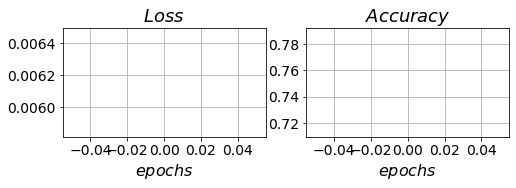

In [4]:
save_model_setting(model_settings,used_model,domains,dataset,save_name)

for i in range(1,number_of_tests+1):
    try_check = i
    
    for test_idx in [0,1,2,3]:
        
        ##########################
        #### Training Setting ####
        ##########################
        if training_setting=='classic':
            train_loader, val_loader, test_loader, optimizer, model, lr_scheduler = classic_setting(
                test_idx, domains, batch_size, is_pretrained, train_tf, test_tf, used_model, pacs_ver
            )
        elif training_setting=='di':
            train_loader, val_loader, test_loader, optimizer, model, lr_scheduler = di_setting(
                test_idx, domains, batch_size, is_pretrained, train_tf, test_tf, used_model, pacs_ver
            )
        elif training_setting=='cc':
            train_loader_stage1,train_loader_stage2, val_loader_stage1, val_loader_stage2, test_loader, optimizer, model, lr_scheduler = cc_setting(
                test_idx, domains, batch_size, is_pretrained, train_tf, test_tf, used_model, pacs_ver
            )
        elif training_setting=='fm':
            train_loader_stage1, train_loader_stage2,val_loader_stage1, val_loader_stage2, test_loader, optimizer, fm_optimizer, model, mixer, lr_scheduler = fm_setting(
                test_idx, domains, batch_size, is_pretrained, train_tf, test_tf, used_model, pacs_ver
            )
        elif training_setting=='byol':
            model,train_loaders=byol_setting(test_idx, domains, byol_batch_size, is_pretrained)
            
            learner = BYOL(
            model,
            image_size = byol_image_size,
            hidden_layer = 'avgpool'
            )
            
            optimizer=torch.optim.Adam(learner.parameters(), lr=byol_lr)
            
            #BYOL training
            byol_training(device, byol_epochs,learner,train_loaders,optimizer)

            #fine-tune용 dataloader
            train_loader, val_loader, test_loader, optimizer, model, lr_scheduler = byol_classic_setting(model,
                test_idx, domains, batch_size, is_pretrained, train_tf, test_tf, used_model, pacs_ver
            )
            
#             torch.save(resnet.state_dict(), './improved-net_'+domains[test_domain_idx]+'.pt')
            
        else:
            raise NotImplementedError
            
        
        save_dir = save_route(test_idx, domains, dataset, save_name, used_model)
        try:
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
        except:
            print('Error : Creating directory. '+ save_dir)
        
                
        ##########################
        ####     Training     ####
        ##########################
        
        if training_setting=='classic':
            model, losses, accuracies = classic_training(
                device, epochs, model,optimizer, criterion, train_loader, val_loader, lr_scheduler
            )
            test_accuracy,_,__=classic_test(device, model,criterion, test_loader,used_model, save_dir, try_check)
        elif training_setting=='di':
            model, losses, accuracies = di_training(
                device, epochs, model,optimizer, criterion, train_loader, val_loader,
                lr_scheduler, is_d_vec=is_domain_vec, gamma_d_loss=gamma_d_loss, is_dc = is_dc, 
                entropy_weight = entropy_weight
            )
            di_test(device, model,criterion, test_loader,used_model, save_dir, try_check,is_d_vec=is_domain_vec, is_dc = is_dc)
        elif training_setting=='cc':
            model, losses, accuracies = cc_training(
                device, epochs, model,optimizer, criterion, train_loader_stage1,train_loader_stage2, val_loader_stage1, val_loader_stage2,
                lr_scheduler, is_d_vec=is_domain_vec, gamma_d_loss=gamma_d_loss, is_dc = is_dc, 
                entropy_weight = entropy_weight
            )
            di_test(device, model,criterion, test_loader,used_model, save_dir, try_check,is_d_vec=is_domain_vec, is_dc = is_dc)
        elif training_setting=='fm':
            model, losses, accuracies = fm_training(
                device, epochs, model, mixer, optimizer, fm_optimizer, criterion, train_loader_stage1, train_loader_stage2, 
                val_loader_stage1, val_loader_stage2, lr_scheduler, is_d_vec=is_domain_vec, gamma_d_loss=gamma_d_loss, is_dc = is_dc, 
                entropy_weight = entropy_weight
            )
            test_accuracy,_,__=di_test(device, model,criterion, test_loader, used_model, save_dir, try_check,is_d_vec=is_domain_vec, is_dc = is_dc)
        elif training_setting=='byol':
            if is_byol_conv_freeze:
                for param in model.parameters():
                    param.requires_grad=False
            
            num_ftrs = model.fc.in_features
            model.fc = torch.nn.Linear(num_ftrs,len(classes))
            model = model.to(device)
            print(model)
            
            model, losses, accuracies = classic_training(
                device, epochs, model,optimizer, criterion, train_loader, val_loader, lr_scheduler
            )
            test_accuracy,_,__=classic_test(device, model,criterion, test_loader,used_model, save_dir, try_check)
            
        else:
            raise NotImplementedError
            
        
        #total result 한번에 보게 결과들 저장하는 텍스트파일    
        total_result_text_path=os.path.join(save_dir,"total_result.txt")
        with open(total_result_text_path,"a") as f:
            print(test_accuracy)
            f.write(str(test_accuracy)+"\n")
            
            
        plotting(losses, accuracies, used_model, save_dir, is_pretrained, try_check)
        save_model(model, used_model, save_dir, is_pretrained, try_check)
        
        

